In [1]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info.operators import Operator, Pauli
import networkx as nx
from qiskit import Aer
import time
import warnings
import scipy
warnings.filterwarnings("ignore")
Z = Pauli('Z')
Z=Operator(Z)
I=Pauli('I')
I=Operator(I)

# 自动随机生成网格及相应边长
使用networkx作为研究工具

生成方法，给定节点数，每两个节点有一定概率相互连接，若连接，就自动生成一个边长


In [2]:
def random():
    weight=np.random.random()
    return weight
def origin_generator(n):
    G=nx.Graph()
    for i in range(0,n):
        G.add_node(i)
    for i in range(0,n):
        for j in range(i+1,n):
            if random()>0.4:
                a=random()
                #print(a)
                G.add_edge(i,j,length=a)
            else:
                continue
    return G
def draw(G):
    nx.draw(G, with_labels=True, node_color='b')

# 自动构建量子线路
qiskit

In [3]:
def QAOA_circuit(n,beta,gamma,p,EVdata):
    cir = QuantumCircuit(n)
    for i in range(0,n):
            cir.h(i)
    for j in range(0,p):        
        for qi,qj,k in EVdata:
            cir.cx(qi,qj)
            cir.rz(2*gamma[j]*k,qj)
            cir.cx(qi,qj)
        for i in range(0,n):
            cir.rx(2*beta[j],i)    
    cir.measure_all()
    return cir
    
    

In [4]:
def const_origin(p):#这个没有用上
    origin=[]
    for i in range(0,p):
        origin.append(random())
        origin.append(random())
    return origin    

In [5]:
def simi_result(circuit):#进行实验测量
    simulator = QasmSimulator()
    compiled_circuit = transpile(circuit, simulator)
    job = simulator.run(compiled_circuit, shots=500)
    result = job.result()
    counts = result.get_counts(compiled_circuit)
    return counts
    
    

In [6]:
def EVcut(EVdata):#图数据转换为处理的问题，量子比特与边长
    first=[]
    second=[]
    length=[]
    for i,j,k in EVdata:
        first.append(i)
        second.append(j)
        length.append(k)
    return first,second,length
        

In [7]:
def classic(n,EVdata):
    group=[]
    v=2**n
    for i in range(0,v):
        str1=str(bin(i))
        str2=str1.lstrip('0b')
        str3=str2.rjust(n,'0')
        group.append(str3)
    value=classic_expectations(EVdata)
    indexmax=value.index(max(value))
    #print(group)
    #print('true_result',group[indexmax])
    #print(max(value))
    return max(value)
def classic_expectations(EVdata):
    v=2**n
    group=[]
    for i in range(0,v):
        str1=str(bin(i))
        str2=str1.lstrip('0b')
        str3=str2.rjust(n,'0')
        group.append(str3)
    total=0
    total1=[]
    first,second,length=EVcut(EVdata)
    for j in range(0,len(group)):
        for i in range(0,len(first)):
            if group[j][first[i]]!=group[j][second[i]]:
                temp=length[i]
                total=total+temp
                #print("yeah")
            else:
                temp=0
                total=total+temp
        total1.append(total)
        total=0
    return total1

In [8]:
def expectations(EVdata,counts):#求取期望
    group=list(counts.keys())
    values=list(counts.values())
    indexmax=values.index(max(values))
    maxnum=group[indexmax]
    total=0
    first,second,length=EVcut(EVdata)
    for i in range(0,len(first)):
        if maxnum[first[i]]!=maxnum[second[i]]:
            temp=length[i]
            total=total+temp
            #print("yeah")
        else:
            temp=0
            total=total+temp
    return total
def maxget(EVdata,counts):
    group=list(counts.keys())
    values=list(counts.values())
    first,second,length=EVcut(EVdata)
    indexmax=values.index(max(values))
    maxnum=group[indexmax]
    total=0
    for i in range(0,len(first)):
        if maxnum[first[i]]!=maxnum[second[i]]:
            temp=length[i]
            total=total+temp
            #print("yeah")
        else:
            temp=0
            total=total+temp
    #print("最大分割",maxnum)
    #print("最大分割值",total)
    return total

# 算法实现
这里使用的是贝叶斯优化器来进行调参，随着步数p的深入，自动生成对应参数数量的优化器

无梯度优化

In [9]:
def optifun(x):
    x=list(x)
    beta=[]
    gamma=[]
    for i in range(0,p):
        beta.append(x[i])
    for j in range(0,p):
        gamma.append(x[j+p])
    cir=QAOA_circuit(n,beta,gamma,p,EVdata)
    counts=simi_result(cir)
    exp=expectations(EVdata,counts)
    return -exp    
#def optimiaztion(): 

In [10]:
import optuna#贝叶斯优化器
def objective(trail):
    names=locals()
    for i in range(0,p):
        names['beta{}'.format(i)]=trail.suggest_float("beta{}".format(i),0,np.pi)
    for i in range(0,p):
        names['gamma{}'.format(i)]=trail.suggest_float("gamma{}".format(i),0,np.pi)
    cir = QuantumCircuit(n)
    for j in range(0,p):  
        for i in range(0,n):
            cir.h(i)
        for qi,qj,k in EVdata:
            cir.cx(qi,qj)
            cir.rz(2*names['gamma{}'.format(j)]*k,qj)
            cir.cx(qi,qj)
        for i in range(0,n):
            cir.rx(2*names['beta{}'.format(j)],i)    
    cir.measure_all()
    counts=simi_result(cir)
    exp=expectations(EVdata,counts)
    return exp

In [11]:
def bounds(p):
    a=(0,np.pi)
    b=(0,np.pi)
    bnd=[]
    for i in range(0,p):
        bnd.append(a)
    for j in range(0,p):
        bnd.append(b)
    bnd=tuple(bnd)
    return bnd
def main(n,p):
    x0=np.array(const_origin(p))
    bnd=bounds(p)
    result=scipy.optimize.minimize(optifun,x0,method='COBYLA',bounds=bnd)
    #print(result)
    #print(result.x)
    pa=list(result.x)
    beta=[]
    gamma=[]
    for i in range(0,p):
        beta.append(pa[i])
    #print(beta)
    for j in range(0,p):
        gamma.append(pa[j+p])
    #print(gamma)
    cirfinal=QAOA_circuit(n,beta,gamma,p,EVdata)
    counts=simi_result(cirfinal)
    #print(counts)
    a=maxget(EVdata,counts)
    return a,counts
    

# 结果输出

问题
节点 0 2 长度 0.07291335331736315
节点 2 3 长度 0.9634078718478071


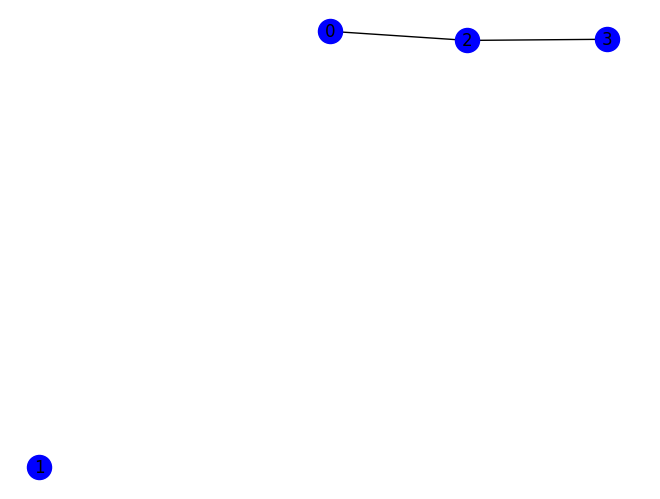

In [12]:
n=4
p=1
G=origin_generator(n)
draw(G)
EVdata = G.edges(data="length")
print("问题")
for i,j,k in EVdata:
    print("节点",i,j,"长度",k)

# 经典

In [13]:
classic(n,EVdata)

1.0363212251651701

In [14]:
re,counts=main(n,p)
print(re)

0.07291335331736315


In [15]:
def aqtest(a,b):
    global n
    global p
    n=a
    p=b    
    count=0
    for i in range(0,100):
        #print("当前进度",i)
        G=origin_generator(n)
        global EVdata
        EVdata = G.edges(data="length")
        max1=classic(n,EVdata)
        max2,counts=main(n,p)
        if max1==max2:
            count=count+1
    print("FINAL ACCURACY",count)
    return count 

In [16]:
list1=[]
for nn in range(3,10):
    print(nn)
    count=aqtest(nn,1)
    list1.append(count)

3


KeyboardInterrupt: 

In [ ]:
aqtest(4,2)

In [17]:
list1=[]
for nn in range(1,6):
    print(nn)
    count=aqtest(4,nn)
    list1.append(count)

1
FINAL ACCURACY 49
2
FINAL ACCURACY 49
3
FINAL ACCURACY 56
4
FINAL ACCURACY 50
5
FINAL ACCURACY 63
